### Imports

In [9]:
import os

def find_path(name, path='/content'):
    '''
    поиск файла или папки
    '''
    result = []
    for root, dirs, files in os.walk(path):
        if name in files+dirs:
          result.append([os.path.join(root, name), root])
    return result

if len(find_path('MyDrive')) == 0 and True:
  from google.colab import drive
  drive.mount('/content/drive')
if True:
  os.chdir(find_path('wishart.py')[0][1])

Mounted at /content/drive


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

### Time series generation

#### Chaotic Dataset

In [11]:
# Skew tent map
def skew_tent_map(n=2**15, omega=0.1847, x0=.5):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, len(x)):
        if x[i-1] < omega:
            x[i] = x[i-1]/omega
        else:
            x[i] = (1-x[i-1])/(1-omega)
    return x

In [12]:
# Logistic map
def logistic_map(n=2**15, r=4, x0=.4):
    x = np.zeros(n)
    x[0] = x0
    for i in range(n-1):
        x[i+1] = r*x[i]*(1-x[i])
    return x

In [13]:
# Schuster's map
def schuster_map(n=2**15, z=2, x0=.5):
    z = float(z)
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i], _ = np.modf(x[i-1] + x[i-1]**z)
    return x

In [14]:
# Henon map
def henon_map(n=1000000, a=1.4, b=0.3, x0=0.2 ,y0=0.1):
    x = np.zeros(n)
    y = np.zeros(n)
    x[0] = x0
    y[0] = y0
    for i in range(1, len(x)):
        x[i] = 1 - a * x[i-1] ** 2 + y[i-1]
        y[i] = b * x[i-1]
    return x

#### Sine Dataset (Deterministic)

In [15]:
sine_data = np.sin(np.arange(0,1000,.01))

#### Gaussian Noise (Stochastic)

In [16]:
gaussian_noise = np.random.normal(size=100000)

#### Lorenz

In [17]:
file_path = 'lorenz.txt'

# Read data from the file into a NumPy array
with open(file_path, 'r') as file:
    # Use numpy to convert the lines into a 1D array of floats
    lorenz = np.array([float(line.strip()) for line in file.readlines()])

# Print the resulting NumPy array
print(lorenz)

[0.53696553 0.57039027 0.68672766 ... 0.6160236  0.71350847 0.86349486]


### Main functions

In [18]:
def prepare_time_series(time_series, N_obs=1000, stepT=1):
    indeces = np.arange(0, len(time_series), stepT)
    return time_series[indeces][:N_obs], stepT

In [19]:
def create_reconstructed_trajectory(time_series, m, J):
    """
    reconstructed_trajectory X can be can be expressed as a
    matrix where each row is a phase-space vector   X = [X1,..,XM].T
    where Xi  is the state of the system at discrete time i. For an N-point time series  {x1,x2,., xN}
    each Xi is given by Xi = [xi, xi+J, ..., xi+(m-1)J]
    J is the lag or reconstruction delay
    m is the embedding dimension
    X is an M × m matrix
    M = N − (m −1)J
    By takens m>2n, but this algo can work with lower m
    """
    N = len(time_series)
    X = []
    index_posns = np.arange(0, m*J, J)

    for i in range(N-(m-1)*J):
      X.append(time_series[index_posns+i])

    X = np.array(X)
    assert X.shape[0]==N-(m-1)*J and X.shape[1]==m
    return X

In [52]:
from tqdm import tqdm
def take_distance_matrix(X):
    return euclidean_distances(X)

In [65]:
def calculate_lambda_9(i, X, distance_matrix, k=1, deltaT=1, mean_period=2):
    """
    M amount of all vectors (X.shape[0]) (number of reconstructing points)
    λ1  is extracted by locating the plateau
    ∆t is the sampling period of the time series
    dj(i) is the distance between the jth pair of nearest neighbors after i discrete-time steps, i.e., i ⋅ ∆t seconds
    """
    neigbours_matrix = distance_matrix.argsort(axis=1)
    M = X.shape[0]
    sum = 0
    divergence = [] # <dj(i)>
    for j in range(1, M-i):
      # dj(i) - растояние между j вектором  и его ближайшим соседом
      # dj(i+k) -расстояние между j вектором  и его ближайшим соседом через несколько шагов
      # правило что бы по вермени были не близки вектора
      for n_ind in neigbours_matrix[j]:
        if abs(n_ind - j)>mean_period:
          neighb_ind = n_ind
          break

      dj_0 = distance_matrix[j][neighb_ind]

      next_vector = j+i
      next_neigb_vector = neighb_ind+i
      if j+i>M-1: next_vector = M-1
      if neighb_ind+i>M-1: next_neigb_vector = M-1

      dj_i = distance_matrix[next_vector][next_neigb_vector]

      if dj_0!=0 and dj_i!=0:
        sum += np.log(dj_i/dj_0)
        divergence.append(np.log(dj_i))

    #print(i, deltaT, M, i, sum)
    lambda_ = 1/(i*deltaT) * 1/(M-i) * sum
    return lambda_, np.array(divergence).mean()

In [27]:
def calculate_lambda_10(i, X, distance_matrix, k=1, deltaT=1, mean_period=2):
    """
    M amount of all vectors (X.shape[0]) (number of reconstructing points)
    k is held constant
    λ1  is extracted by locating the plateau
    ∆t is the sampling period of the time series
    dj(i) is the distance between the jth pair of nearest neighbors after i discrete-time steps, i.e., i ⋅ ∆t seconds
    """
    M = X.shape[0]
    sum = 0
    divergence = [] # <dj(i)>
    for j in range(1, M-k+1):
      # dj(i) - растояние между j вектором  и его ближайшим соседом
      # dj(i+k) -расстояние между j вектором  и его ближайшим соседом через несколько шагов
      # правило что бы по вермени были не близки вектора
      neighb_ind_list = distance_matrix[j].argsort()
      for n_ind in neighb_ind_list:
        if abs(n_ind - j)>mean_period:
          neighb_ind = n_ind
          break

      if j+i>M-1 or neighb_ind+i>M-1 or j+i+k>M-1 or neighb_ind+i+k>M-1:
        continue
      else:
        dj_i = distance_matrix[j+i][neighb_ind+i]
        dj_ik = distance_matrix[j+i+k][neighb_ind+i+k]
        if dj_i!=0 and dj_ik!=0:
          sum += np.log(dj_ik/dj_i)
          divergence.append(np.log(dj_ik))

    lambda_ = 1/(k*deltaT) * 1/(M-k) * sum
    return lambda_, np.array(divergence).mean()

In [79]:
import matplotlib.pyplot as plt
def plot_divergence(divergence, lyap_exponent, intercept, time_plato):
    plt.plot(np.arange(1, len(divergence)+1, 1), divergence, 'k')
    plt.axline((0, intercept), slope=lyap_exponent, color="b", label=f"LyapExp={lyap_exponent:.4f} by linreg")
    plt.axvline(time_plato, color='k', linestyle='--', label='time_plato', alpha=.5)
    plt.plot(np.arange(1, len(divergence)+1, 1), divergence, 'k')

    # Add title and labels
    plt.title('<ln(divergence)> by time')
    plt.xlabel('time')
    plt.ylabel('<ln(divergence)>')

    # Add legend
    plt.legend()
    # Display the plot
    plt.show()

In [ ]:
def DEPRECATED_estimate_lyapunov_exponent(time_series,
                               N_obs=1000,
                               stepT=1,
                               m=5,
                               calculate_lambda=calculate_lambda_9,
                               J=1,
                               i_list=[1],
                               k=1,
                               deltaT=1,
                               mean_period=3):

    time_series_prep, stepT = prepare_time_series(time_series, N_obs=N_obs, stepT=stepT)
    X = create_reconstructed_trajectory(time_series_prep, m, J)
    A = take_distance_matrix(X)
    lambda_list = []
    divergence_list = []
    for i in i_list:
      lambda_, div = calculate_lambda_9(i=i, X=X, distance_matrix=A, k=k, deltaT=deltaT, mean_period=mean_period)
      lambda_list.append(lambda_)
      divergence_list.append(div)
    return lambda_list, divergence_list, X, A

In [80]:
def estimate_lyapunov_exponent(time_series,
                               N_obs=1000,
                               stepT=1,
                               m=5,
                               calculate_lambda=calculate_lambda_9,
                               J=1,
                               k=1,
                               deltaT=1,
                               mean_period=3,
                               time_max=50,
                               time_plato=30,
                               plotGraph=True):

    time_series_prep, stepT = prepare_time_series(time_series, N_obs=N_obs, stepT=stepT)
    X = create_reconstructed_trajectory(time_series_prep, m, J)
    A = take_distance_matrix(X)
    lambda_list = []
    divergence_list = []
    for i in range(1, time_max):
      lambda_, div = calculate_lambda_9(i=i, X=X, distance_matrix=A, k=k, deltaT=deltaT, mean_period=mean_period)
      lambda_list.append(lambda_)
      divergence_list.append(div)

    lyap_exponent, intercept = np.polyfit(np.arange(1, len(divergence_list[:time_plato]) + 1), divergence_list[:time_plato], 1)
    print(f'Lyapunov Exponent {lyap_exponent:.4f}')

    if plotGraph: plot_divergence(divergence_list, lyap_exponent, intercept, time_plato)

    return lyap_exponent, intercept, lambda_list, divergence_list, X, A

### Experiments

#### Lorenz

Lyapunov Exponent 0.0616


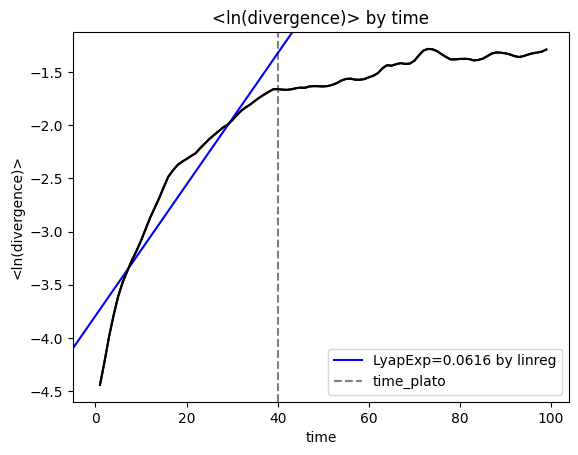

In [82]:
_ = estimate_lyapunov_exponent(lorenz,
                               N_obs=1000,
                               stepT=1,
                               m=3,
                               J=1,
                               k=1,
                               deltaT=1,
                               mean_period=3,
                               time_max=100,
                               time_plato=40
                               )

#### Logistic

Lyapunov Exponent 0.6237


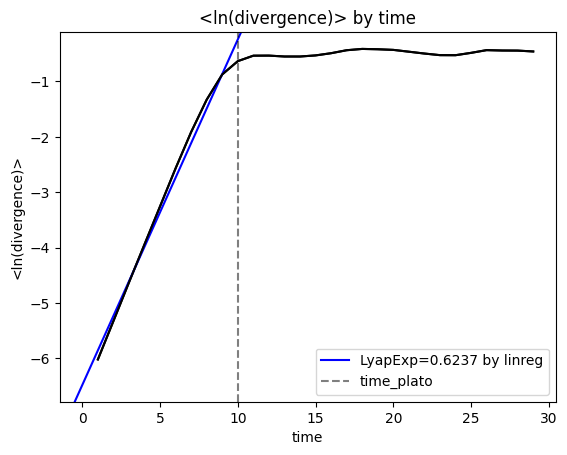

In [84]:
_ = estimate_lyapunov_exponent(logistic_map(),
                               N_obs=1000,
                               stepT=1,
                               m=3,
                               J=1,
                               k=1,
                               deltaT=1,
                               mean_period=3,
                               time_max=30,
                               time_plato=10
                               )

#### Hénon

Lyapunov Exponent 0.3195


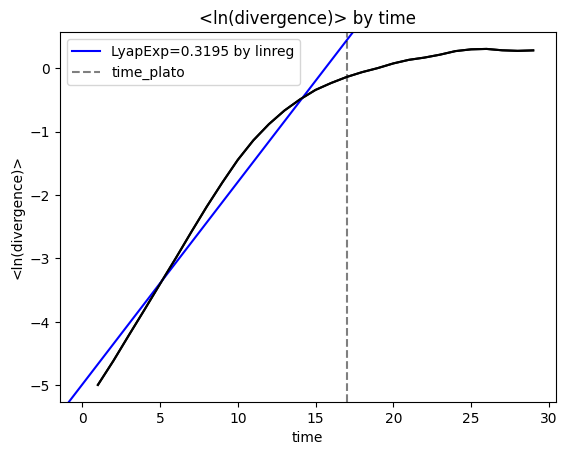

In [88]:
_ = estimate_lyapunov_exponent(henon_map(),
                               N_obs=1000,
                               stepT=1,
                               m=3,
                               J=1,
                               k=1,
                               deltaT=1,
                               mean_period=3,
                               time_max=30,
                               time_plato=17
                               )